In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 17})
import folium
import re
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

class DataFrame(object):

    def __init__(self,file_path):
        """Create df object
        Parameters
        ----------
        file_path: takes in a file path to raw data
        """
        self.file_path = file_path
        
    def clean(self):
        '''
        Parameters
            self: self
        Returns
            a cleaned df
        '''
        df = pd.read_csv(self.file_path,encoding='latin1')
        df.dropna(inplace=True)
        df.drop(['permalink','region','founded_month','founded_quarter'],axis=1,inplace=True)
        df['founded_at'] = pd.to_datetime(df['founded_at'],errors='coerce')
        df['first_funding_at']= pd.to_datetime(df['first_funding_at'],errors='coerce')
        df['last_funding_at']= pd.to_datetime(df['first_funding_at'],errors='coerce')
        df['founded_year'] = df['founded_year'].astype('int64')
        df.drop(df[df['country_code']=='CAN'].index,inplace=True)
        df['funding_total_usd'] = df[' funding_total_usd '].apply(lambda x: x.replace(' ',''))\
            .apply(lambda x: x.replace(',',''))
        df['funding_total_usd'] = df['funding_total_usd'].apply(lambda x: x.replace('-','0'))
        df['funding_total_usd'] = df['funding_total_usd'].astype('int64')
        df['market'] = df[' market '].apply(lambda x: x.replace(' ','')) 
        df.drop([' market ',' funding_total_usd ','country_code','homepage_url','name','city','last_funding_at', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H','category_list'],axis=1,inplace=True)
        return df

def feature_engineer(df):
    '''
    Parameters
        df: Takes in a pandas data frame
    Returns
        a data frame with engineered features
    '''
    df['time_to_funding'] = abs((df['first_funding_at']-df['founded_at']).dt.days)
    test_list = list(df['market'].value_counts()\
        .rename_axis('market').reset_index(name='counts')[:20]['market'])
    df.loc[~df["market"].isin(test_list), "market"] = "Other"
    df.dropna(inplace=True)
    return df

def add_finance(symbol,df):
    '''
    Parameters
        symbol: stock ticker
        df: data frame to add 
    Returns
        a data frame with engineered features
    '''
    finance = yf.Ticker(symbol)
    fin_df = finance.history(period="max")
    fin_df['avg']=(fin_df['Open']+fin_df['Close'])/2
    fin_df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'],axis=1,inplace=True)
    fin_df['first_funding_at'] = fin_df.index
    
    no_finance_data = list(clean_feat_df[clean_feat_df['first_funding_at']<fin_df['first_funding_at'].min()].index)
    df.drop(no_finance_data,inplace=True)
    df.set_index('first_funding_at')
    df = df.merge(fin_df,on='first_funding_at')
    return df

In [2]:
    intial_df = DataFrame('../../../Downloads/investments_VC.csv').clean()
    clean_feat_df=feature_engineer(intial_df)
    clean_feat_df=add_finance('^VIX',clean_feat_df)
    
    #change funding from to dollars to ones and zeros
    funding_type_df = clean_feat_df.loc[:,'seed':'product_crowdfunding']\
        .apply(lambda x: x>0).astype('int64')
    funding_type_df.drop('undisclosed',axis=1,inplace=True)

    #make dummies
    col_list = ['Advertising', 'Analytics', 'Biotechnology', 'CleanTechnology',
       'Consulting', 'CuratedWeb', 'E-Commerce', 'Education',
       'EnterpriseSoftware', 'Finance', 'Games', 'Hardware+Software',
       'HealthCare', 'HealthandWellness', 'Manufacturing', 'Mobile',
       'Security', 'Semiconductors', 'SocialMedia', 'Software','Other']
    market_dummies = pd.get_dummies(clean_feat_df['market']).reindex(columns=col_list)
    state_dummies = pd.get_dummies(clean_feat_df['state_code'])

    #set targets as ones and zeros
    clean_feat_df['status'] = clean_feat_df['status'].apply(lambda x: x.replace('operating','0'))\
        .apply(lambda x: x.replace('acquired','1')).apply(lambda x: x.replace('closed','0'))
    clean_feat_df['status'] = clean_feat_df['status'].astype('int64')

In [25]:
    #set X and Y, test train split and SMOTE                           
    X =market_dummies.iloc[:,:20].join(state_dummies.iloc[:,:50])\
        .join(clean_feat_df['time_to_funding']).join(clean_feat_df['avg']).join(funding_type_df).values
    y=clean_feat_df['status'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    #build logisitic model
    log_model = LogisticRegression(solver="lbfgs",max_iter=300)
    log_model.fit(X_train, y_train)
    y_predict_log = log_model.predict(X_test)

    #build random forest model
    rf = RandomForestClassifier(max_features=42, n_estimators=100)
    rf.fit(X_train, y_train)
    y_predict_rf = rf.predict(X_test)

In [26]:
def eval_model(model, X_test, y_test,threshold):
#     predicted_proba = model.predict_proba(X_test)
#     preds = (predicted_proba [:,1] >= threshold).astype('int')
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print('===ACCURACY===')
    print(acc)
    print('===RECALL===')
    print(rec)
    print('===PRECISION===')
    print(prec)
    print('===F1===')
    print(f1)

In [27]:
thresh_list= np.linspace(0,1,101)
profit = []
for val in thresh_list:
    threshold = val
    predicted_proba = rf.predict_proba(X_test)
    preds = (predicted_proba [:,1] >= threshold).astype('int')
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    invest = 100000
    yearly_return = .27
    hold_per=8
    profit.append(round((tp/(tn+fp+fn+tp))*(((1+yearly_return)**hold_per)*invest)-((fp/(tn+fp+fn+tp))*invest),2))

In [28]:
thresh_list= np.linspace(0,1,101)
log_profit = []
for val in thresh_list:
    threshold = val
    predicted_proba_log = log_model.predict_proba(X_test)
    preds_log = (predicted_proba_log [:,1] >= threshold).astype('int')
    log_tn, log_fp, log_fn, log_tp = confusion_matrix(y_test, preds_log).ravel()
    invest = 100000
    yearly_return = .27
    hold_per=8
    log_profit.append(round((log_tp/(log_tn+log_fp+log_fn+log_tp))*(((1+yearly_return)**hold_per)*invest)-((log_fp/(log_tn+log_fp+log_fn+log_tp))*invest),2))

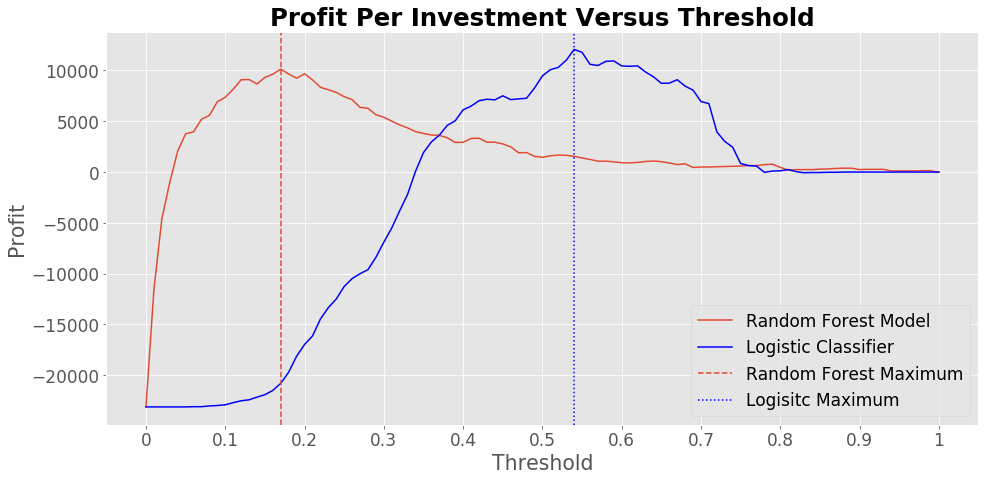

In [35]:
rand_x=[0,100]
rand_y=[profit[0],0]
    
fig,ax = plt.subplots(figsize=(14,7))
ax.plot(profit,label='Random Forest Model')
ax.plot(log_profit,label='Logistic Classifier',c='blue')
ax.set_xlabel('Threshold')
ax.set_ylabel('Profit')
ax.set_title('Profit Per Investment Versus Threshold',fontweight='bold')
ax.axvline(x=np.argsort(profit)[100],label='Random Forest Maximum',ls='--')
ax.axvline(x=np.argsort(log_profit)[100],label='Logisitc Maximum',ls=':',c='blue')
ax.legend()
plt.xticks([0,10,20,30,40,50,60,70,80,90,100],labels=['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1'])
plt.tight_layout()
# plt.savefig('../images/profit_threshold',dpi=500)


In [36]:
profit_curve_rf = []
cum_profit_rf = 0
sorted_y = y_test[(np.argsort(rf.predict_proba(X_test)[:,1])[::-1])]
for i in sorted_y:
    if i==1:
        cum_profit_rf += (((1+yearly_return)**hold_per)*invest)
        profit_curve_rf.append(cum_profit_rf)
    else:
        cum_profit_rf -=invest
        profit_curve_rf.append(cum_profit_rf)
        
profit_curve_log = []
cum_profit_log = 0
sorted_y_log = y_test[(np.argsort(log_model.predict_proba(X_test)[:,1])[::-1])]
for i in sorted_y_log:
    if i==1:
        cum_profit_log += (((1+yearly_return)**hold_per)*invest)
        profit_curve_log.append(cum_profit_log)
    else:
        cum_profit_log -=invest
        profit_curve_log.append(cum_profit_log)

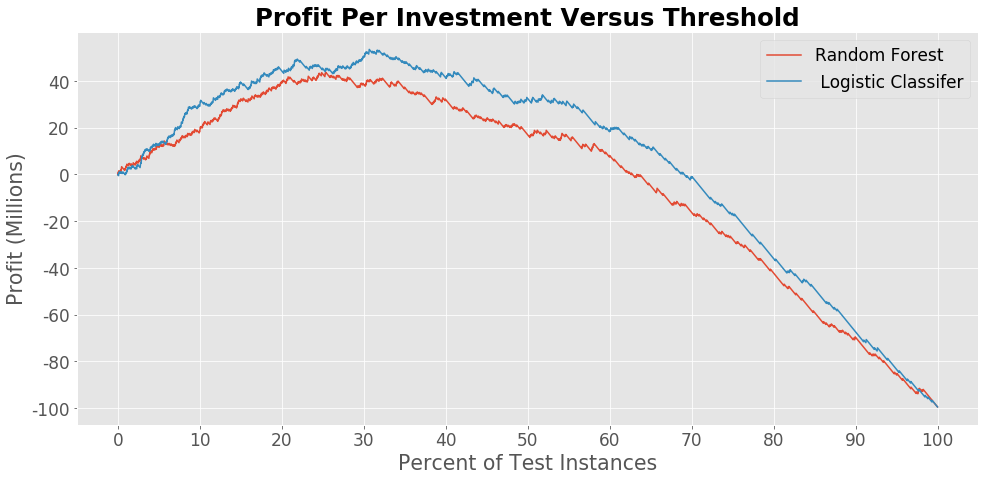

In [37]:
fig,ax = plt.subplots(figsize=(14,7))
ax.plot(profit_curve_rf,label='Random Forest')
ax.plot(profit_curve_log,label=' Logistic Classifer')
ax.legend()
ax.set_yticks([-100000000,-80000000,-60000000,-40000000,-20000000,0,20000000,40000000])
ax.set_yticklabels(['-100','-80','-60','-40','-20','0','20','40'])
ax.set_xticks(np.linspace(0,4304,11))
ax.set_xticklabels([0,10,20,30,40,50,60,70,80,90,100])
ax.set_xlabel('Percent of Test Instances')
ax.set_ylabel('Profit (Millions)')
ax.set_title('Profit Per Investment Versus Threshold',fontweight='bold')
plt.tight_layout()
# plt.savefig('../images/profit_curve',dpi=500)

In [ ]:
#invest = $100,000
#yearly_return = 27%
#hold_per=8 years


# Robert Wiltbank, PhD,  states that 27% returns actually are the average for 
#startup investments in the United States. Robert is a Professor of Strategic Management & Entrepreneurship for 
#the Atkinson Graduate School of Management at Willamette University